<a href="https://colab.research.google.com/github/kenanmorani/Audio_Signal_Processing_For_Music_Applications_idu/blob/main/Ptich%20Extraction/Lecture5_2_f0Est_CompareLibs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lecture 2, f0 detection using Essentia - Melodia:

In this example, we demonstrate use of the predominant melody extraction function of Essentia, discuss the influence of analysis parameter choice on the estimated pitch info and also demonstrate use of [mir_eval](https://github.com/craffel/mir_eval) library to evaluate its performance. 

There is no student version of this notebook

In [ ]:
!pip install essentia mir_eval pysoundfile

     |████████████████████████████████| 12.0MB 3.7MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp36-none-any.whl size=96515 sha256=95b4deed5b2e26ecaad99a602ca8401a1f38b0a8ba22d7c62ad2a0c5e97879f7
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [ ]:
import os
from essentia import *
from essentia.standard import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
import soundfile as sf
import urllib.request
from IPython.display import Audio

In [ ]:
url = 'https://github.com/MTG/MIRCourse/raw/master/data/baris/eh.wav'
fileName = 'eh.wav'
urllib.request.urlretrieve(url,fileName)
x, fs = sf.read(fileName)
x = x / np.max(np.abs(x))#amplitude normalisation
print('Sampling frequency: ', fs, 'Hz')
minF0 = 50 #in Hz
maxF0 = 2000 #in Hz
windowSize = 4096
hopSize = 1024
w = get_window('blackman', windowSize)
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
numWindows = startIndexes.size
Audio(x, rate=fs)

Sampling frequency:  44100 Hz


In [ ]:
run_predominant_melody = PitchMelodia(guessUnvoiced = True,
                                      frameSize = windowSize,
                                      hopSize = hopSize,
                                      maxFrequency = 2000,
                                      minFrequency = 50,
                                      sampleRate = fs);

#x = EqualLoudness()(x)
f0, confidence = run_predominant_melody(x)

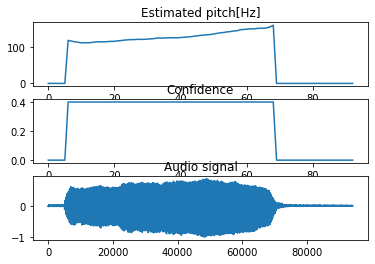

In [ ]:
#Plotting estimated pitch, confidence with audio
f, axarr = plt.subplots(3)
axarr[0].plot(f0)
axarr[0].set_title('Estimated pitch[Hz]')
axarr[1].plot(confidence)
axarr[1].set_title('Confidence')
axarr[2].plot(x)
axarr[2].set_title('Audio signal')
plt.show()

In [ ]:
#Saving estimated values to file
fileNameF0 = fileName.replace('.wav','.f0_preDomMel.txt')
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
with open(fileNameF0, 'w') as f:
    for k in range(startIndexes.size):
        time = (startIndexes[k] + windowSize / 2) / fs
        f.write(str(time) + '\t' + str(f0[k]) + '\n')

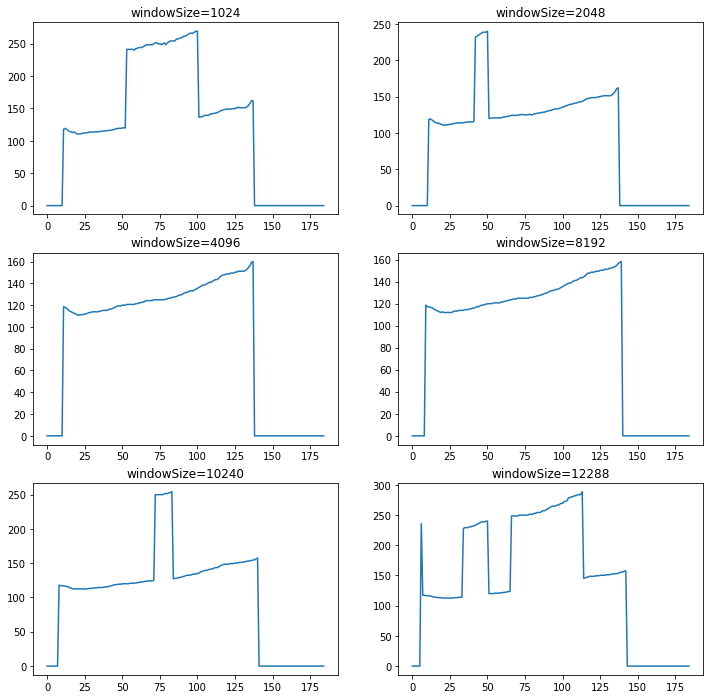

In [ ]:
#Demonstrating influence of parameters in estimation
winSizeValues = np.array([1,2,4,8,10,12])*1024
numFrm2plot = len(winSizeValues)
plt.figure(figsize = (12, numFrm2plot * 2))
plotInd = 1
hopSize = 1024//2
for windowSize in winSizeValues:
    run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize, sampleRate = fs);
    f0, confidence = run_predominant_melody(x)
    plt.subplot(numFrm2plot / 2, 2, plotInd)
    plt.plot(f0)
    plt.title('windowSize=' + str(windowSize))
    plotInd += 1

### Let's now evaluate Essentia's performance on a file from a Mirex test dataset:

We will use [mir-eval](https://github.com/craffel/mir_eval) Python library ([documentation](http://craffel.github.io/mir_eval/)) presented in:
Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, ["mir_eval: A Transparent Implementation of Common MIR Metrics"](http://colinraffel.com/publications/ismir2014mir_eval.pdf), Proceedings of the 15th International Conference on Music Information Retrieval, 2014.

File resource: https://labrosa.ee.columbia.edu/projects/melody/ 

In [ ]:
#This cell downloads a subset of the UIOWA:MIS dataset
import urllib.request
import zipfile
import os, sys,shutil

main_data_dir = 'data'
if not os.path.exists(main_data_dir):#creating the directory if not exist
    os.mkdir(main_data_dir)

targetDir = os.path.join(main_data_dir,'melody')
if not os.path.exists(targetDir):#creating the director
    os.mkdir(targetDir)

#Link for example files on https://www.ee.columbia.edu/~graham/mirex_melody/ 
url = 'http://www.ee.columbia.edu/~graham/mirex_melody/melody_example_files.zip'
filename = url.split('/')[-1]
urllib.request.urlretrieve(url,filename)
#Unzipping to a specific folder
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(targetDir)
zip_ref.close()
os.remove(filename)#Removing the zip file
print('Data downloaded and unzipped to: ',targetDir)

Data downloaded and unzipped to:  data/melody


In [ ]:
import mir_eval
dataFolder = 'data/melody/melody_example_files/'

#Reading ground-truth
ref_time, ref_freq = mir_eval.io.load_time_series(os.path.join(dataFolder, 'example1REF.txt'))

#Running Essentia predominant melody extraction and saving to an output file
hopSize = 441#10 miliseconds
windowSize = 4096
fs = 44100
run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize,sampleRate=fs)
x = MonoLoader(filename = dataFolder+'example1.wav', sampleRate = fs)()
#x = EqualLoudness()(x)
f0, confidence = run_predominant_melody(x)
startIndexes = np.arange(0, x.size-windowSize,hopSize, dtype=int)
with open(dataFolder + 'train01MEL_estimated.txt', 'w') as f:
    for k in range(startIndexes.size):
        f.write(str(k*0.01) + '\t' + str(f0[k]) + '\n')

#Re-reading Essentia estimation results
est_time, est_freq = mir_eval.io.load_time_series(dataFolder + 'train01MEL_estimated.txt')

#Running evaluation and ptinting
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
for score in scores:
    print(score,'\t',scores[score])

Voicing Recall 	 0.9573400250941029
Voicing False Alarm 	 0.6338028169014085
Raw Pitch Accuracy 	 0.7233375156838143
Raw Chroma Accuracy 	 0.7766624843161857
Overall Accuracy 	 0.5989370400654129


In [ ]:
!pip install crepe
import crepe

#Reading ground-truth
ref_time, ref_freq = mir_eval.io.load_time_series(os.path.join(dataFolder, 'example1REF.txt'))

#Running Essentia predominant melody extraction and saving to an output file
hopSize = 441#10 miliseconds
windowSize = 4096
fs = 44100
x = MonoLoader(filename = dataFolder+'example1.wav', sampleRate = fs)()
#x = EqualLoudness()(x)

est_time, est_freq, confidence, activation = crepe.predict(x, fs, viterbi=True)

#Running evaluation and ptinting
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
for score in scores:
    print(score,'\t',scores[score])

77/77 [==============================] - 116s 2s/step
Voicing Recall 	 1.0
Voicing False Alarm 	 1.0
Raw Pitch Accuracy 	 0.9560853199498118
Raw Chroma Accuracy 	 0.9573400250941029
Overall Accuracy 	 0.6230580539656582


In [ ]:
#Downloading a standard mir dataset
!pip install mirdata
import mirdata
orchset = mirdata.initialize('orchset')
orchset.download()

In [ ]:
#Collecting audio file names 
all_files = []
for root, dirs, files in os.walk('/root/mir_datasets/orchset/audio/mono/'):
    for file in files:
        if file.endswith('.wav'):
            file_name = os.path.join(root,file)
            all_files.append(file_name)


/root/mir_datasets/orchset/audio/mono/Tchaikovsky-SwanLake-Scene-ex2.wav
/root/mir_datasets/orchset/audio/mono/Musorgski-Ravel-PicturesExhibition-ex10.wav
/root/mir_datasets/orchset/audio/mono/Beethoven-S5-II-ex1.wav
/root/mir_datasets/orchset/audio/mono/Grieg-PeerGynt-MorningMood-ex2.wav
/root/mir_datasets/orchset/audio/mono/Holst-ThePlanets-Jupiter-ex2.wav
/root/mir_datasets/orchset/audio/mono/Holst-ThePlanets-Jupiter-ex1.wav
/root/mir_datasets/orchset/audio/mono/Rimski-Korsakov-Scheherazade-YoungPrincePrincess-ex3.wav
/root/mir_datasets/orchset/audio/mono/Musorgski-Ravel-PicturesExhibition-Promenade1-ex2.wav
/root/mir_datasets/orchset/audio/mono/Musorgski-Ravel-PicturesExhibition-ex7.wav
/root/mir_datasets/orchset/audio/mono/Dvorak-S9-IV-ex3.wav
/root/mir_datasets/orchset/audio/mono/Haydn-S94-Menuet-ex1.wav
/root/mir_datasets/orchset/audio/mono/Beethoven-S5-II-ex2.wav
/root/mir_datasets/orchset/audio/mono/Strauss-BlueDanube-ex1.wav
/root/mir_datasets/orchset/audio/mono/Musorgski-Rav